In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report 
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit,StratifiedShuffleSplit
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization
import torch
import torch.nn as nn
import torch.nn.functional as F

C:\Users\flame\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
test = pd.read_csv('poker-hand-testing.data')
train = pd.read_csv('poker-hand-training-true.data')

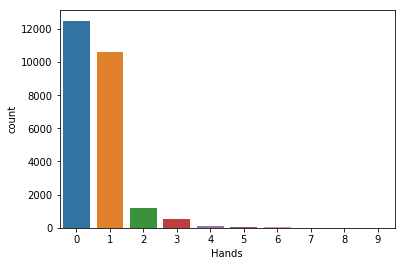

In [5]:
#From the count plot we can see that there is a really big class imbalance in the training data set.
#In order to deal with this, a stratifiedshuffle split will be used on our dataset to ensure that 
#at least some of the samples make it into both the training and validation sets.
sns.countplot('9',data=train)
plt.xlabel('Hands')
plt.show()

In [6]:
train['9'].value_counts()/len(train)

0    0.499540
1    0.423807
2    0.048223
3    0.020513
4    0.003719
5    0.002159
6    0.001439
7    0.000240
8    0.000200
9    0.000160
Name: 9, dtype: float64

In [7]:
y = train['9']
X = train.drop('9',axis=1)
folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)

In [8]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = lgb.LGBMClassifier(**params, n_estimators=20000, nthread=-1)

    test_pred_proba = np.zeros((train.shape[0], 10))
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
        model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
                verbose=False, early_stopping_rounds=200)

        y_pred_valid = model.predict_proba(X_valid)

        test_pred_proba[valid_idx] = y_pred_valid

    return accuracy_score(y_valid, y_pred_valid.argmax(1))

In [54]:
# params = {'colsample_bytree': (0.6, 0.8),
#       'learning_rate': (.0001, .5), 
#       'num_leaves': (2, 124), 
#       'subsample': (0.6, 1), 
#       'max_depth': (3, 120), 
#       'reg_alpha': (.001, 15.0), 
#       'reg_lambda': (.001, 15.0), 
#       'min_split_gain': (.001, .03),
#       'min_child_weight': (2, 80)}

# bo = BayesianOptimization(lgbm_evaluate, params)
# bo.maximize(init_points=5, n_iter=10)

In [55]:
# params = bo.max['params']
# params['num_leaves'] = 4
# params['max_depth'] =5
# test_pred_proba = np.zeros((train.shape[0], 10))
# folds = StratifiedShuffleSplit(n_splits=4, test_size=0.2)
# for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train, y)):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
#         model = lgb.LGBMClassifier(**params, n_estimators = 10000, n_jobs = -1)
#         model.fit(X_train, y_train, 
#                 eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='multi_logloss',
#                 verbose=False, early_stopping_rounds=200)

#         y_pred_valid = model.predict_proba(X_valid)

#         test_pred_proba[valid_idx] = y_pred_valid

#         print(accuracy_score(y_valid, y_pred_valid.argmax(1)))

In [56]:
# y = test['0']
# X = test.drop('0',axis=1)
# test_pred_proba = np.zeros((test.shape[0], 10))
# y_pred_valid = model.predict_proba(X)
# #test_pred_proba[valid_idx] = y_pred_valid
# print(accuracy_score(y, y_pred_valid.argmax(1)))

In [57]:
cm = confusion_matrix(y,y_pred_valid.argmax(1))
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')

In [58]:
# After Bayesian Optimization, the this lightGBM model could only predict ~65.5% accuracy
#This could be because random forest struggles with fitting models that have 
#high class imbalances 

In [57]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, 100)
        self.layer3 = nn.Linear(100,num_classes)
        self.sigmoid = nn.Sigmoid()
        self.softmax1 = nn.Softmax()
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.sigmoid(out)
        out = self.softmax1(out)
        return out

In [58]:
model = NeuralNet(10,50,10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [34]:
X_train = torch.from_numpy(X.values.astype(np.float32))
y = torch.from_numpy(y.values)

AttributeError: 'Tensor' object has no attribute 'values'

In [59]:

for epoch in range(500):
    # Forward Propagation
    y_pred = model(X_train)
    # Compute and print loss
    loss = criterion(y_pred, y)
    print('epoch: ', epoch,' loss: ', loss.item())
    # Zero the gradients
    optimizer.zero_grad()
    
    # perform a backward pass (backpropagation)
    loss.backward()
    
    # Update the parameters
    optimizer.step()

epoch:  0  loss:  2.3002140522003174
epoch:  1  loss:  2.299712657928467
epoch:  2  loss:  2.2992055416107178
epoch:  3  loss:  2.2986927032470703
epoch:  4  loss:  2.298190116882324
epoch:  5  loss:  2.297677755355835
epoch:  6  loss:  2.2971746921539307
epoch:  7  loss:  2.2966487407684326
epoch:  8  loss:  2.296144962310791
epoch:  9  loss:  2.295632839202881
epoch:  10  loss:  2.2951223850250244
epoch:  11  loss:  2.294611692428589
epoch:  12  loss:  2.2940971851348877
epoch:  13  loss:  2.2935750484466553
epoch:  14  loss:  2.293074131011963
epoch:  15  loss:  2.2925732135772705
epoch:  16  loss:  2.2920644283294678
epoch:  17  loss:  2.2915632724761963
epoch:  18  loss:  2.2910609245300293
epoch:  19  loss:  2.2905569076538086
epoch:  20  loss:  2.2900664806365967
epoch:  21  loss:  2.2895684242248535
epoch:  22  loss:  2.2890727519989014
epoch:  23  loss:  2.2885727882385254
epoch:  24  loss:  2.28808331489563
epoch:  25  loss:  2.287602424621582
epoch:  26  loss:  2.28712201118

epoch:  217  loss:  2.2379982471466064
epoch:  218  loss:  2.2378499507904053
epoch:  219  loss:  2.2377099990844727
epoch:  220  loss:  2.2375662326812744
epoch:  221  loss:  2.23742413520813
epoch:  222  loss:  2.2372825145721436
epoch:  223  loss:  2.2371442317962646
epoch:  224  loss:  2.2370080947875977
epoch:  225  loss:  2.236865520477295
epoch:  226  loss:  2.236729860305786
epoch:  227  loss:  2.2365939617156982
epoch:  228  loss:  2.2364563941955566
epoch:  229  loss:  2.236321449279785
epoch:  230  loss:  2.2361929416656494
epoch:  231  loss:  2.2360661029815674
epoch:  232  loss:  2.235935688018799
epoch:  233  loss:  2.2358031272888184
epoch:  234  loss:  2.235677719116211
epoch:  235  loss:  2.2355475425720215
epoch:  236  loss:  2.235419273376465
epoch:  237  loss:  2.2352914810180664
epoch:  238  loss:  2.2351622581481934
epoch:  239  loss:  2.235041379928589
epoch:  240  loss:  2.2349119186401367
epoch:  241  loss:  2.234788417816162
epoch:  242  loss:  2.2346692085266

epoch:  433  loss:  2.2215492725372314
epoch:  434  loss:  2.22151255607605
epoch:  435  loss:  2.2214789390563965
epoch:  436  loss:  2.2214455604553223
epoch:  437  loss:  2.221412181854248
epoch:  438  loss:  2.2213783264160156
epoch:  439  loss:  2.2213449478149414
epoch:  440  loss:  2.2213103771209717
epoch:  441  loss:  2.221273183822632
epoch:  442  loss:  2.2212393283843994
epoch:  443  loss:  2.2212073802948
epoch:  444  loss:  2.2211737632751465
epoch:  445  loss:  2.221139907836914
epoch:  446  loss:  2.221107006072998
epoch:  447  loss:  2.221074342727661
epoch:  448  loss:  2.2210443019866943
epoch:  449  loss:  2.221011161804199
epoch:  450  loss:  2.220975875854492
epoch:  451  loss:  2.220946788787842
epoch:  452  loss:  2.2209160327911377
epoch:  453  loss:  2.2208828926086426
epoch:  454  loss:  2.220848798751831
epoch:  455  loss:  2.220817804336548
epoch:  456  loss:  2.22078275680542
epoch:  457  loss:  2.2207486629486084
epoch:  458  loss:  2.220720052719116
epoc

In [60]:
X_test = torch.from_numpy(test.drop('0',axis=1).values.astype(np.float32))
y_test = torch.from_numpy(test['0'].values)

In [61]:
y_pred = model(X_test)
y_pred = pd.Series(torch.max(y_pred,1)[1].numpy())

In [62]:
accuracy_score(y_test,y_pred)

0.4872034872034872

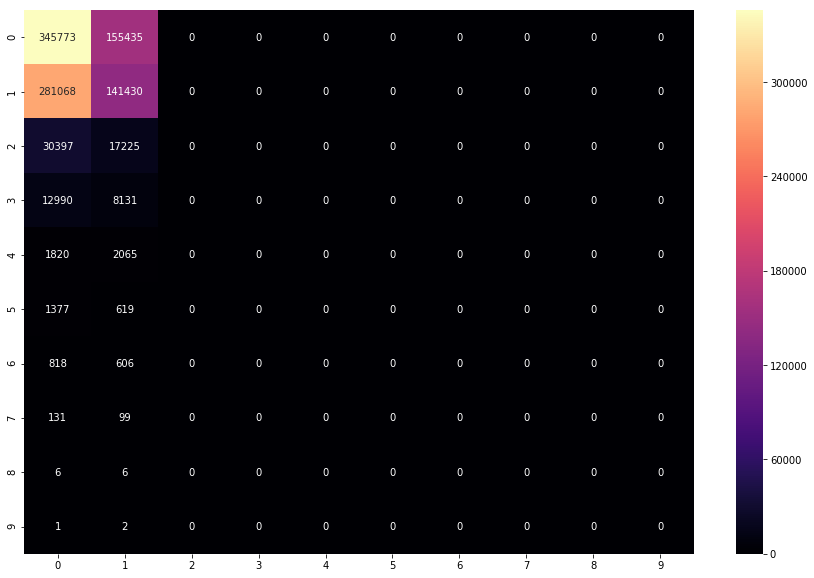

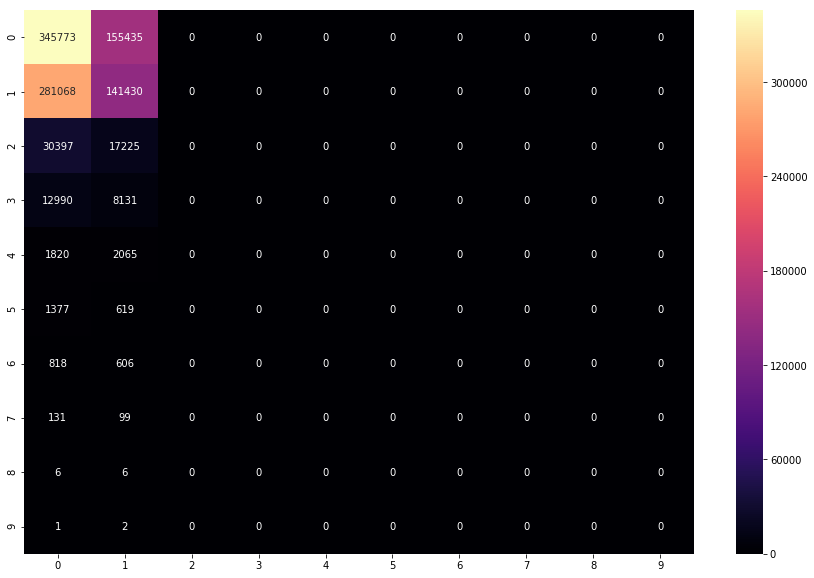

In [64]:
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (15,10))
sns.heatmap(df_cm, annot=True, cmap = 'magma', fmt='g')
plt.show()